In [1]:
import numpy as np;
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv
from MountainCar import * ## We import the script from the MountainCar.py

## THE TASK, Definition

 The car depicted in the figure needs to reach the goal location. However, it does not have enough power to reach it directly and it needs to oscillate to build up momentum. The agent can make three possible actions: to go right, left, or to wait. A reward of 1 is delivered if the car reaches the goal, otherwise the reward is -1. 

<img src="Env.png" width="500" height="500">

The difficulty of task is due to: the agent can start improving its policy only after it has reached the goal location, the optimal strategy includes actions where the agent goes further from the goal location. 


## THE ENVIRONMENT, Definition

MountainCar.py contains the class MountainCar, which has three methods.

1- .reset It resets the environment to the starting location and velocity of the car. The staring location is random in the interval $[-0.6-0.4[$, the starting velocity is $0$.

2- .step Taking as input the action made, it updates the environment (computes the new position and velocity) and gives the reward. The output of the method consists of: the new position, the new velocity, the reward, a boolean variable that is True in the case the final location has been reached and False otherwise.

3- .Create_Animation Taking as input a succession of locations, it generates an animation.

An example of two agents, one at the beginning of training that is unable to solve the task, and one after training, are shown in the animations below. 




In [2]:
## Definde the environment

Env=MountainCar()

<IPython.core.display.Javascript object>


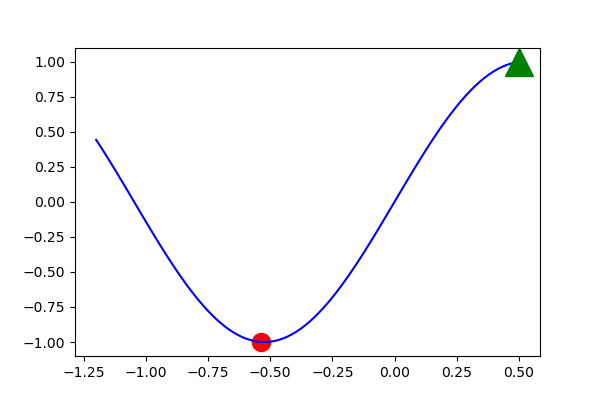

In [3]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## Loading the positions of an episode run by the agent after training (saved in GoodAgent.npy) 
Position_GoodAgent=np.load('GoodAgent.npy')

## Loading the positions of an episode run by an agent before training (saved in GoodAgent.npy) 
Position_BadAgent=np.load('BadAgent.npy')

# Select Good=1 to create an animation for the data of the optimised agent.
# Select Good=0 to create an animation for the data of the agent before training.

Good=1
if Good==1:
    
    anim=Env.Create_Animation(Position_GoodAgent)
    plt.show()

else:
    
    anim=Env.Create_Animation(Position_BadAgent)
    plt.show()


## Definition of the states

We will use radial basis functions to define the states. For the current problem, positions and velocities compose a 2-d space. As in the tabular method,  let's decompose the space by dividing the $x$ and $v$ variables into different $N_x$ and $N_v$ different positions. These latter positions, equally spaced across the $(x,v)$ space, will define the center of activities of different nodes. A particular node $i$ with center of activity $(x^c_i,v^c_i)$ will respond maximally when the agent has a position-velocity pair $(x,v)=$(x^c_i,v^c_i)$. The node i will instead respond weakly when the agent is far away from its center of activity. 

Mathematically, given an agent at position $(x,v)$, the node $i$ with center $(x^c_i,v^c_i)$ will have activity

$$s_i\propto \exp\big(-\dfrac{(x-x^c_i)^2}{2\sigma_x^2}-\dfrac{(v-v^c_i)^2}{2\sigma_v^2}\big)$$

where $\sigma_x$ and $\sigma_v$ control the size of the region where the node will have considerable activity. 
If we define nodes with different centers equally spaced across the $(x,v)$ space, compute their activities and plot them across the two dimensions, we would find 

<img src="Input_example.png" width="800" height="800">

for an agent in the position $(0,0)$. These activities will constitute the input to a perceptron that approximates the Q-values.
The cell below contains the class InputNodes, which defines the different responses of the neurons. Its method ComputeNodes takes as input the position and speed of the agent and outputs two variable: the first corresponds to the nodes' activities, collected in a 1-d vector; the second contains the nodes' activities in a 2-d matrix for illustration purposes. 




In [5]:
## In this case, we will use value function approximation
## Instead of defining a table of Q-values, we will define our states and approximate the Q-values thanks to a perceptron

## CREATE THE COORDINATES OF THE TABLE AND INTIALISE Q-VALUES

N_x=20   ## NUMBER OF CENTERS ACROSS THE POSITION

N_v=20   ## NUMBER OF CENTERS ACROSS THE VELOCITY


class InputNodes:
    
    def __init__(self, N_x, N_v):
        
        self.X_m=-1.2       ## MINIMUM POSITION
        self.X_M=0.5        ## MAXIMUM POSITION
        
        self.sigma_x=(self.X_M-self.X_m)/20 
        
        
        self.V_m=-0.07      ## MINIMUM SPEED
        self.V_M=0.07       ## MAXIMUM SPEED
        
        self.sigma_v=(self.V_M-self.V_m)/20

        
        self.N_x=N_x       ## NUMBER OF INPUT NODES ENCODING POSITION
        self.N_v=N_v       ## NUMBER OF INPUT NODES ENCODING VELOCITIES
        
        self.X0=np.linspace(self.X_m,self.X_M,self.N_x)      ## Centers for positions
        self.V0=np.linspace(self.V_m,self.V_M,self.N_v)      ## Centers for velocities
        
        X_c,V_c=np.meshgrid(self.X0, self.V0)     ## Centers in 2-d
        self.X_c=X_c
        self.V_c=V_c
        
        self.N=N_x*N_v     ## TOTAL NUMBER OF INPUT NODES
        
        
    def ComputeNodes(self,x,v):
        
        ## COMPUTE INPUT NODES ACTIVITIES
        Input_2d=1/np.sqrt(2*self.sigma_x**2+2*self.sigma_v**2*np.pi)*np.exp(-((x-self.X_c)**2/(2*self.sigma_x**2)+(v-self.V_c)**2/(2*self.sigma_v**2)) )
        Input=np.reshape(Input_2d,[-1])
        
        return Input,Input_2d
    
Nodes=InputNodes(N_x,N_v)    
    

N_a=3 ## NUMBER OF ACTIONS   

## The Q-values will be initialised with small random numbers centered around zero. Thus, considering that all the rewards are 
## -1 except the one at the goal location, this initialisation performs an optimistic policy and encourages exploration despite
## the choice of a small value of epsilon. The Q-values will need to decay from 0 to -1 at the beginning of training. Thus, 
## after the Q-value of a specific state-action pair has been updated and has decayed, the agent will try the other available 
## actions. 

W=np.random.randn(N_a,Nodes.N)/1000

gamma=0.99 ## gamma value
epsilon=0.01 ## epsilon value for the exploration
eta=0.0005 ## learning rate


<IPython.core.display.Javascript object>


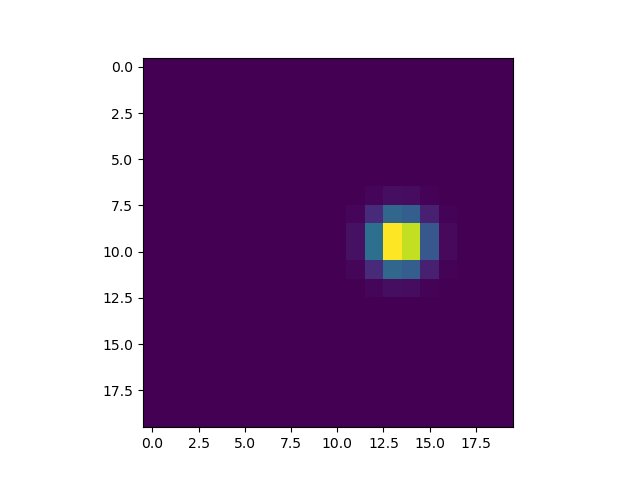

[-0.0019165   0.01377913  0.0110323 ]


In [6]:
## Example, try to change the input to the method and see the results
## Try to vary sigma_x , sigma_y and/or the variables N_x and N_v to see the consequences
## Please set N_x=20 and N_v=20, not much more, when you start the training loop (the total number of nodes is N_x*N_v, for 
## high values the algorithm will be slow)

plt.figure()
X,X_2d=Nodes.ComputeNodes(0,0)

# This is analogous to the example plot above, but in 2-d with different colours
plt.imshow(X_2d)

# The starting value for the Q-values at the position and speed considered
Qvalues=np.matmul(W,X)
print(Qvalues)



In [7]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:

        a=np.random.randint(0,N_a)

    else:

        a=np.argmax(Qvalues)
            
    return a

##  The SARSA algorithm with value function approximation

<img src="SARSA_valueFunctionApprox_scheme.png" width="1000" height="700">


In [8]:
## TRAINING LOOP
## For each episode, the episode ends when the car reaches the goal. However, if the car has not reached the goal after 1000
## steps, please terminate the episode and reset the environemnt.


N_episodes=10000 ## Number of episodes
N_a=1000         ## Maximum number of actions per episode

## To perform the analysis below, please save the Positions, Speeds, Dones (the done value that the method Env.step() returns), and rewards 
## for each step and episode in the following arrays

Positions=np.zeros([N_episodes,N_a])
Speeds=np.zeros([N_episodes,N_a])
Dones=np.zeros([N_episodes,N_a])
Rs=np.zeros([N_episodes,N_a])

for n in range(N_episodes):
    
    # Initialise the position and velocity
    [pos,speed]=Env.reset()
    
    X,_=Nodes.ComputeNodes(pos,speed)
    
    # Find the Qvalues corresponding to that state
    Qvalues=np.matmul(W,X)
    
    # Make an action
    a=EpsilonGreedy_Policy(Qvalues,epsilon)
    
    
    for t in range(N_a):
        
        Qvalues=np.matmul(W,X)
        
        # Update the position and the velocity
        [pos1,speed1],R,Done=Env.step(a)
        
        # Save the position and velocities
        Speeds[n,t]=np.copy(speed1)
        Positions[n,t]=np.copy(pos1)
        Dones[n,t]=np.copy(Done)
        Rs[n,t]=np.copy(R)
        
        # If the episode has ended and the car has reached the goal, we reset the environment to a starting location
        if Done==True:
            
            # Compute the delta
            delta=R-Qvalues[a]
            
            # Update the Qvalues
            W[a,:]=W[a,:]+eta*delta*X
            
            break;
            
            
        # Compute Input
        X1,_=Nodes.ComputeNodes(pos,speed)
        
        # Find the Qvalues
        Qvalues1=np.matmul(W,X1)
        
        # Make an action with epsilon-greedy policy
        a1=EpsilonGreedy_Policy(Qvalues1,epsilon)
        
        # Compute the delta
        delta=R+gamma*Qvalues1[a1]-Qvalues[a]
        
        # Update the weights
        W[a,:]=W[a,:]+eta*delta*X
        
        # The new state and action become the current state and action
        a=np.copy(a1)
        pos=np.copy(pos1)
        speed=np.copy(speed1)
        
        # The new position becomes the current position, so we can copy also the nodes' activities
        X=np.copy(X1)
            
        

In [ ]:
## PLOT THE BEST EPISODE
## The code in this cell will select the best episode (with highest reward) and animate it
## You will need to have saved the arrays Rs and Positions


from matplotlib.animation import FuncAnimation
%matplotlib notebook

Best_episode=np.argmax(np.sum(Rs,1))
Steps=int(np.abs(np.sum(Rs[Best_episode,:]))+1)

print('The Best Episode is the number: ', Best_episode, 'Number of steps: ', Steps)

Position=np.copy(Positions[Best_episode,0:Steps])    
anim=Env.Create_Animation(Position)
plt.show()



In [ ]:
## PLOT THE TOTAL REWARD PER EPISODE AS TRAINING PROGRESSES
## You will need the array Rs

fig=plt.subplots(1,1)
plt.plot(np.sum(Rs,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()
